# For learning ML developing in a regression task
*By: Patcharanat P.*

Predict MaxTemp, MinTemp, and MeanTemp using other features as input.

this notebook includes multiple aspect of developing model as following:
- Filling missing value with a Mean or Median value
- RandomForestRegressor
- Multivariate feature imputation (IterativeImputer)
- (MSE and MAE explaination)
- a Baseline model & a Benchmark model
- Normalization (MinMaxScaler, RobustScaler, StandardScaler exclude Normalizer)
- Using time series cross validator (In progress...)

read README.md for more detail

> Note that the dataset used in this project wasn't given definition of each column, so domain knowledge or feature engineering won't be apply in the project.

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('dark')

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
import time

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

## Data Pre-processing (Load Data & Data Cleaning)

In [2]:
df = pd.read_csv('Summary of Weather.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-

In [4]:
df.head(10)

,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10001,1942-7-6,0,NaN,26.666667,21.666667,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10001,1942-7-7,T,NaN,28.333333,22.777778,25.555556,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10001,1942-7-8,3.556,NaN,26.666667,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10001,1942-7-9,T,NaN,27.222222,22.777778,25.000000,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10001,1942-7-10,3.556,NaN,25.555556,21.666667,23.333333,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.isnull().sum().sum()

1834179

In [6]:
df = df.dropna(axis=1, how='all')
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df_temp = df.drop(columns=['Date'])

invalid values are filled in DataFrame. So, we need to specify which columns contain the invalid values in order to exclude or deal with it.

In [8]:
for e in df_temp.columns:
    if df_temp[e].dtypes == 'O':
        print(e)

Precip
Snowfall
PoorWeather
PRCP
SNF
TSHDSBRSGF


Above columns have multiple types of value in a single column (storing different type in a single column), which give us a sense that it tend to have invalid value.

In [9]:
df_temp2 = df_temp[['Precip', 'Snowfall', 'PoorWeather', 'PRCP', 'SNF', 'TSHDSBRSGF']]
print(df_temp2.isnull().sum())

Precip             0
Snowfall        1163
PoorWeather    84803
PRCP            1932
SNF             1163
TSHDSBRSGF     84803
dtype: int64


df_temp2 store suspicious columns that are likely have to be cleaned.

After apply .astype(float) method for each column, we found that 'PoorWeather' and 'TSHDSBRSGF' columns have multiple invalid values such as '1   1' which are hard to deal with. So, we decided to drop both columns and keep the others.

In [10]:
for e in df_temp.columns:
    if df_temp[e].astype(str).str.contains('T').any():
        print(e)

Precip
PRCP
SNF


In [11]:
for e in df_temp.columns:
    if df_temp[e].astype(str).str.contains('#VALUE!').any():
        print(e)

Snowfall


These columns contain 'T' or '#VALUE!' which are invalid values. So, I will replace it with np.nan

In [12]:
df_temp = df_temp.drop(columns=['TSHDSBRSGF', 'PoorWeather'])
df_temp[['Precip', 'PRCP', 'SNF']] = df_temp[['Precip', 'PRCP', 'SNF']].replace('T', np.nan)
df_temp['Snowfall'] = df_temp['Snowfall'].replace('#VALUE!', np.nan)
df_temp = df_temp.astype(float)

In [13]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  float64
 1   Precip       102287 non-null  float64
 2   WindGustSpd  532 non-null     float64
 3   MaxTemp      119040 non-null  float64
 4   MinTemp      119040 non-null  float64
 5   MeanTemp     119040 non-null  float64
 6   Snowfall     117833 non-null  float64
 7   YR           119040 non-null  float64
 8   MO           119040 non-null  float64
 9   DA           119040 non-null  float64
 10  PRCP         100355 non-null  float64
 11  DR           533 non-null     float64
 12  SPD          532 non-null     float64
 13  MAX          118566 non-null  float64
 14  MIN          118572 non-null  float64
 15  MEA          118542 non-null  float64
 16  SNF          117833 non-null  float64
 17  SND          5563 non-null    float64
 18  PGT          525 non-nul

### Fill missing values

Before we're going to fill missing value, we have to decide what we're going to fill it with such as mean, median (mode won't be used in this case). So, we will use MinMaxScaler to preserve and observe its distribution. If the column contain SOME of outliers, using a mean of that column wouldn't be appropriate because the mean value would be affected too much by outliers, so we will use median instead. On the other hand, if the column contain NO OULIER or SIGNIFICANT MULTIPLE OF OUTLIERs, we will use mean in order to fill missing value with the most general or nature of the column.

In [14]:
min_max_scaler = MinMaxScaler()
df_temp2 = pd.DataFrame(min_max_scaler.fit_transform(df_temp))
df_temp2.columns = list(df_temp.columns)
df_temp2

,STA,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,PRCP,DR,SPD,MAX,MIN,MEA,SNF,SND,PGT
0,0.0,0.003306,NaN,0.706667,0.832061,0.786765,0.0,0.4,0.545455,0.000000,0.003306,NaN,NaN,0.706667,0.832061,0.786765,0.0,NaN,NaN
1,0.0,0.000000,NaN,0.746667,0.824427,0.808824,0.0,0.4,0.545455,0.033333,0.000000,NaN,NaN,0.746667,0.824427,0.808824,0.0,NaN,NaN
2,0.0,0.008264,NaN,0.713333,0.832061,0.794118,0.0,0.4,0.545455,0.066667,0.008264,NaN,NaN,0.713333,0.832061,0.794118,0.0,NaN,NaN
3,0.0,0.008264,NaN,0.720000,0.832061,0.794118,0.0,0.4,0.545455,0.100000,0.008264,NaN,NaN,0.720000,0.832061,0.794118,0.0,NaN,NaN
4,0.0,0.000000,NaN,0.720000,0.824427,0.794118,0.0,0.4,0.545455,0.133333,0.000000,NaN,NaN,0.720000,0.824427,0.794118,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119035,1.0,0.000000,NaN,0.740000,0.778626,0.779412,0.0,1.0,1.000000,0.866667,0.000000,NaN,NaN,0.740000,0.778626,0.779412,0.0,NaN,NaN
119036,1.0,0.032231,NaN,0.753333,0.778626,0.786765,0.0,1.0,1.000000,0.900000,0.032231,NaN,NaN,0.753333,0.778626,0.786765,0.0,NaN,NaN
119037,1.0,0.000000,NaN,0.740000,0.778626,0.779412,0.0,1.0,1.000000,0.933333,0.000000,NaN,NaN,0.740000,0.778626,0.779412,0.0,NaN,NaN
119038,1.0,0.000000,NaN,0.740000,0.778626,0.779412,0.0,1.0,1.000000,0.966667,0.000000,NaN,NaN,0.740000,0.778626,0.779412,0.0,NaN,NaN


P.S. df_temp2 in only used for observing distribution to decide method of imputation. Now, we still hold on df_temp as main a DataFrame.

<AxesSubplot:>

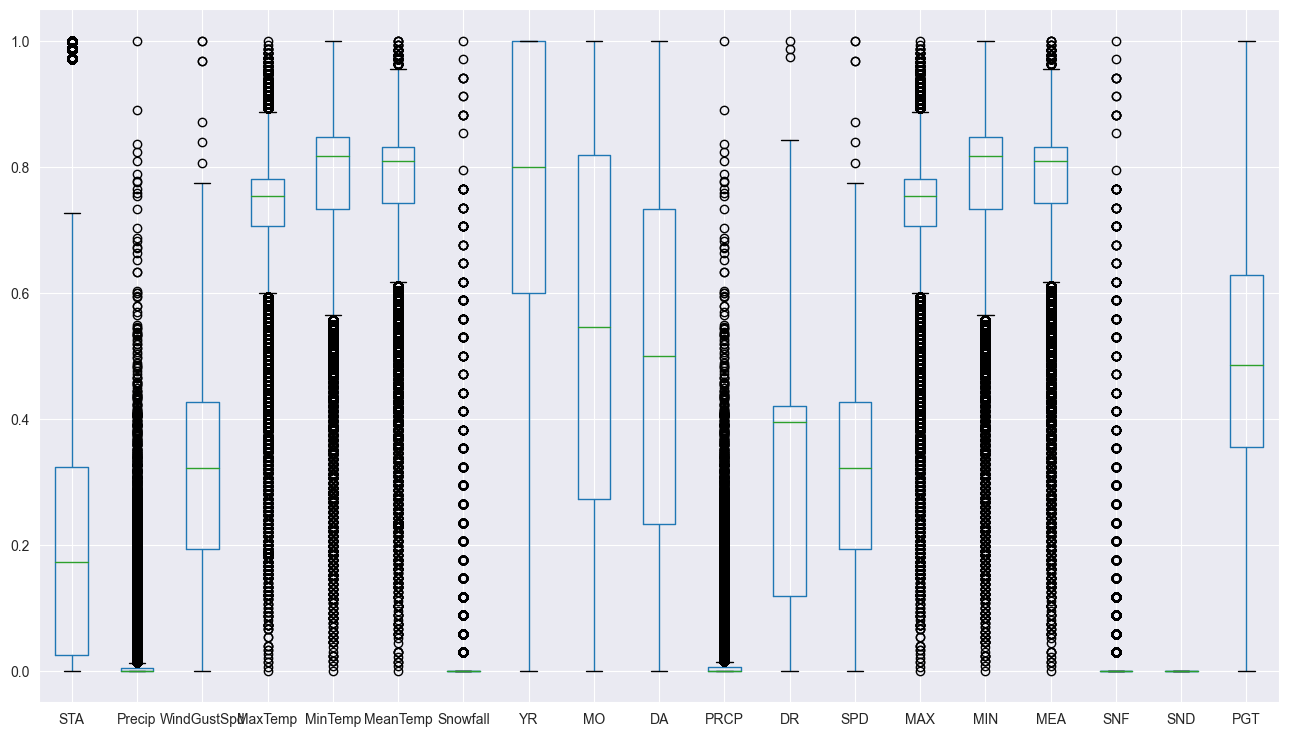

In [15]:
fig = plt.figure(figsize=(16, 9))
df_temp2.boxplot()

From boxplot above, we're able to decide which columns should be filled na with 'mean' or 'median'. The one that has **low amount of outliers** will be filled na with 'median', and the other will be 'mean'.

In [16]:
df_temp['SND'].value_counts()

0.0    5563
Name: SND, dtype: int64

From boxplot and describe() method, column 'SND' quite doesn't make sense to take into ML model due to duplicated values 0 and NaN. So drop off the column would be better. 

In [17]:
df_temp5 = df_temp.drop(columns=['SND'])

> Notice that *df_temp5* is a DataFrame before filling missing value but already cleaned at a step. We will use *df_temp5* later in other aspect of developing.

In [18]:
# will be filled with median
df_temp3 = df_temp5[['STA', 'WindGustSpd', 'DR', 'SPD']]

# will be filled with mean
df_temp4 = df_temp5.drop(['STA', 'WindGustSpd', 'DR', 'SPD'], axis=1)

fill missing values

In [19]:
pd.options.mode.chained_assignment = None  # default='warn'

for col in df_temp3.columns:
    df_temp3[col] = df_temp3[col].fillna(df_temp3[col].median())
for col in df_temp4.columns:
    df_temp4[col] = df_temp4[col].fillna(df_temp4[col].mean())

In [20]:
print(df_temp3.isnull().sum())
print(df_temp4.isnull().sum())

STA            0
WindGustSpd    0
DR             0
SPD            0
dtype: int64
Precip      0
MaxTemp     0
MinTemp     0
MeanTemp    0
Snowfall    0
YR          0
MO          0
DA          0
PRCP        0
MAX         0
MIN         0
MEA         0
SNF         0
PGT         0
dtype: int64


Both type columns are filled, next we will concatenate or aggregate into a DataFrame

In [21]:
df_temp = pd.concat([df_temp3, df_temp4], axis=1)

And also insert column *'Date'* as it had before. Then, we're going back to use df instead of df_temp as our main DataFrame which is already cleaned.

In [22]:
df_temp.insert(loc=0, column='Date', value=df['Date'])
df = df_temp
df

,Date,STA,WindGustSpd,DR,SPD,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,PRCP,MAX,MIN,MEA,SNF,PGT
0,1942-07-01,10001.0,37.04,32.0,20.0,1.016,25.555556,22.222222,23.888889,0.0,42.0,7.0,1.0,0.04,78.0,72.0,75.0,0.0,12.085333
1,1942-07-02,10001.0,37.04,32.0,20.0,0.000,28.888889,21.666667,25.555556,0.0,42.0,7.0,2.0,0.00,84.0,71.0,78.0,0.0,12.085333
2,1942-07-03,10001.0,37.04,32.0,20.0,2.540,26.111111,22.222222,24.444444,0.0,42.0,7.0,3.0,0.10,79.0,72.0,76.0,0.0,12.085333
3,1942-07-04,10001.0,37.04,32.0,20.0,2.540,26.666667,22.222222,24.444444,0.0,42.0,7.0,4.0,0.10,80.0,72.0,76.0,0.0,12.085333
4,1942-07-05,10001.0,37.04,32.0,20.0,0.000,26.666667,21.666667,24.444444,0.0,42.0,7.0,5.0,0.00,80.0,71.0,76.0,0.0,12.085333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119035,1945-12-27,82506.0,37.04,32.0,20.0,0.000,28.333333,18.333333,23.333333,0.0,45.0,12.0,27.0,0.00,83.0,65.0,74.0,0.0,12.085333
119036,1945-12-28,82506.0,37.04,32.0,20.0,9.906,29.444444,18.333333,23.888889,0.0,45.0,12.0,28.0,0.39,85.0,65.0,75.0,0.0,12.085333
119037,1945-12-29,82506.0,37.04,32.0,20.0,0.000,28.333333,18.333333,23.333333,0.0,45.0,12.0,29.0,0.00,83.0,65.0,74.0,0.0,12.085333
119038,1945-12-30,82506.0,37.04,32.0,20.0,0.000,28.333333,18.333333,23.333333,0.0,45.0,12.0,30.0,0.00,83.0,65.0,74.0,0.0,12.085333


In [23]:
df.describe()

,STA,WindGustSpd,DR,SPD,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,PRCP,MAX,MIN,MEA,SNF,PGT
count,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000
mean,29659.435795,37.043283,31.977604,20.001773,3.753917,27.045111,17.789511,22.411631,0.245544,43.805284,6.726016,15.797530,0.150637,81.003745,64.273808,72.644843,0.009667,12.085333
std,20953.209402,0.689520,1.070991,0.372311,10.721867,8.717817,8.334572,8.297982,2.613250,1.136718,3.425561,8.794541,0.421693,14.839727,14.453003,14.181324,0.102884,0.380256
min,10001.000000,18.520000,2.000000,10.000000,0.000000,-33.333333,-38.333333,-35.555556,0.000000,40.000000,1.000000,1.000000,0.000000,-28.000000,-37.000000,-32.000000,0.000000,0.000000
25%,11801.000000,37.040000,32.000000,20.000000,0.000000,25.555556,15.000000,20.555556,0.000000,43.000000,4.000000,8.000000,0.000000,78.000000,59.000000,69.000000,0.000000,12.085333
50%,22508.000000,37.040000,32.000000,20.000000,0.000000,29.444444,21.111111,25.555556,0.000000,44.000000,7.000000,16.000000,0.000000,85.000000,70.000000,78.000000,0.000000,12.085333
75%,33501.000000,37.040000,32.000000,20.000000,3.753917,31.666667,23.333333,27.222222,0.000000,45.000000,10.000000,23.000000,0.150637,89.000000,74.000000,81.000000,0.000000,12.085333
max,82506.000000,75.932000,78.000000,41.000000,307.340000,50.000000,34.444444,40.000000,86.360000,45.000000,12.000000,31.000000,12.100000,122.000000,94.000000,104.000000,3.400000,23.900000


Define Input and Output

In [24]:
def split_data(df):
    Y = df[['Date', 'MaxTemp', 'MinTemp', 'MeanTemp']]
    X = df.drop(columns=['MaxTemp', 'MinTemp', 'MeanTemp'])

    X = X.set_index('Date')
    Y = Y.set_index('Date')

    # test size = 0.2
    cutoff = int(df.shape[0]*0.8)

    X_train = df.loc[:cutoff, X.columns]
    y_train = df.loc[:cutoff, Y.columns]

    X_test = df.loc[cutoff:, X.columns]
    y_test = df.loc[cutoff:, Y.columns]

    return X_train, X_test, y_train, y_test

In [25]:
X_train, X_test, y_train, y_test = split_data(df)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95233, 15) (95233, 3) (23808, 15) (23808, 3)


## Model Development
*Model: RandomForestRegressor*

In [26]:
model_RF = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)

param_grid = [{
    'n_estimators': [100, 200, 300, 400],
    'criterion': ['squared_error'],
    'max_depth': [3, 4, 5, 6],
    'max_features': ['sqrt', 'log2', 0.3, 0.4],
    'min_samples_leaf': [4, 6, 10, 12, 15, 20]
}]

# grid = GridSearchCV(model, param_grid=param_grid)
random_search_RF = RandomizedSearchCV(
                          estimator=model_RF,
                          param_distributions=param_grid,
                          cv=tscv,
                          scoring='neg_mean_squared_error',
                          verbose=1
                          )


In [27]:
t0 = time.time()
random_search_RF.fit(X_train, y_train)
t1 = time.time() - t0
print("Fit time: ", t1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fit time:  235.97600507736206


In [28]:
print(random_search_RF.best_params_)

{'n_estimators': 400, 'min_samples_leaf': 12, 'max_features': 0.4, 'max_depth': 6, 'criterion': 'squared_error'}


In [29]:
model_rf_tuned = RandomForestRegressor(**random_search_RF.best_params_)
model_rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=0.4, min_samples_leaf=12,
                      n_estimators=400)

In [30]:
def make_predict_score(y_test, prediction):
    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)

    print('r2: ', r2, '\n', 'mse: ', mse, '\n', 'mae: ', mae)
    return r2, mse, mae

In [31]:
prediction = model_rf_tuned.predict(X_test)
print('score on test set')
r2_1_test, mse_1_test, mae_1_test = make_predict_score(y_test, prediction)

score on test set
r2:  0.9589074395841992 
 mse:  0.9253449778042993 
 mae:  0.5925128183700862


In [32]:
prediction = model_rf_tuned.predict(X_train)
print('score on train set')
r2_1_train, mse_1_train, mae_1_train = make_predict_score(y_train, prediction)

score on train set
r2:  0.9890732083729589 
 mse:  0.8991201436060448 
 mae:  0.582542581546424


---

## Other approaches of ML developing

### Multivariate feature imputation (IterativeImputor)

Using IterativeImputor is a more sophisticated approach to fill missing values, but instead it's harder to explain its algorithm, formula, or associated fucnction. Read more about the Multivariate Imputation's algorithm [here.](https://cran.r-project.org/web/packages/miceRanger/vignettes/miceAlgorithm.html)

Using Multivariate feature imputation (IterativeImputer), and scaler for an another approach, start from the point before we filled missing value (df_temp5)

In [33]:
df_temp5.isnull().sum()

STA                 0
Precip          16753
WindGustSpd    118508
MaxTemp             0
MinTemp             0
MeanTemp            0
Snowfall         1207
YR                  0
MO                  0
DA                  0
PRCP            18685
DR             118507
SPD            118508
MAX               474
MIN               468
MEA               498
SNF              1207
PGT            118515
dtype: int64

In [34]:
imp = IterativeImputer(random_state=1)
array_temp = imp.fit_transform(df_temp5)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [35]:
array_temp

array([[1.00010000e+04, 1.01600000e+00, 3.77756305e+01, ...,
        7.50000000e+01, 0.00000000e+00, 1.43335731e+01],
       [1.00010000e+04, 0.00000000e+00, 3.77756305e+01, ...,
        7.80000000e+01, 0.00000000e+00, 1.43323900e+01],
       [1.00010000e+04, 2.54000000e+00, 3.77756305e+01, ...,
        7.60000000e+01, 0.00000000e+00, 1.43340132e+01],
       ...,
       [8.25060000e+04, 0.00000000e+00, 3.77745338e+01, ...,
        7.40000000e+01, 0.00000000e+00, 3.32728025e+00],
       [8.25060000e+04, 0.00000000e+00, 3.77745338e+01, ...,
        7.40000000e+01, 0.00000000e+00, 3.32727830e+00],
       [8.25060000e+04, 0.00000000e+00, 3.77745338e+01, ...,
        7.40000000e+01, 0.00000000e+00, 3.32752208e+00]])

In [36]:
len(array_temp)

119040

The result from IterativeImputer gave us array type so we need to convert to dataFrame form.

In [37]:
df_temp = pd.DataFrame(
    data = array_temp,
    index = df_temp5.index,
    columns = df_temp5.columns
)
df_temp.insert(loc=0, column='Date', value=df['Date'])

In [38]:
X_train, X_test, y_train, y_test = split_data(df_temp)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(95233, 15) (23808, 15) (95233, 3) (23808, 3)


In [39]:
model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=4, max_features='sqrt', bootstrap=True, random_state=1)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, max_features='sqrt', random_state=1)

In [40]:
prediction = model.predict(X_test)
print('score on test set')
r2_2_test, mse_2_test, mae_2_test = make_predict_score(y_test, prediction)

score on test set
r2:  0.7978878289313057 
 mse:  4.7499331010794945 
 mae:  1.6578994633248723


In [41]:
prediction = model.predict(X_train)
print('score on train set')
r2_2_train, mse_2_train, mae_2_train = make_predict_score(y_train, prediction)

score on train set
r2:  0.9343439613514807 
 mse:  5.416664036306922 
 mae:  1.6383403801277805


Comparing performance by Imputer

In [42]:
comparing_score = {
    'R-squared': [r2_1_test, r2_1_train, r2_2_test, r2_2_train],
    'MSE': [mse_1_test, mse_1_train, mse_2_test, mse_2_train],
    'MAE': [mae_1_test, mae_1_train, mae_2_test, mae_2_train]
}
score_df = pd.DataFrame(
    comparing_score,
    index=[
        'traditional method on test set',
        'traditional method on train set',
        'IterativeImputer method on test set',
        'IterativeImputer method on train set'
    ]
)
score_df

,R-squared,MSE,MAE
traditional method on test set,0.958907,0.925345,0.592513
traditional method on train set,0.989073,0.899120,0.582543
IterativeImputer method on test set,0.797888,4.749933,1.657899
IterativeImputer method on train set,0.934344,5.416664,1.638340


First, we determine the model performance by the traditional method on the test set and training set. We can see that R-squared on the training set got a better score. It means the model was able to explain all of the variances in the dependent variable better in the training set which is understandable because we use the training set to train the model. So, it's somewhat acceptable if the R-squared score on the training set is higher than on the test set, and also doesn't mean it overfitting.

Second, errors on the test set are lower than on the training set meaning that the model performed better on the test set and did not overfit.

Third, we determine the model performance between the traditional method and the multivariate imputation method. As we can see that Iterative Imputer got a higher R-squared score and a lower MSE meaning that the model can perform better with this approach, but something to be noticed carefully is MAE.

Using multivariate imputer led to a higher MAE compared with the traditional method. My assumption is it was an effect of outliers. According to multivariate imputer, the multivariate imputer algorithm is to define a feature with missing values as a target and other features as input then use a regressor to predict missing values and replace them in the data frame. **Here's the point, we use multiple of outliers as input for imputing missing values, then the filled values would depend on outliers.** However, MSE is something known as sensitive to outliers but got a better score because of the effect of the outliers. shouldn't MSE get higher for imputing more values dependent on outliers? The answer is no. MSE is actually sensitive to outliers, but when outliers increase, MSE will no longer detect them as outliers, instead, it will detect them as another different property of data. The result is a better overall performance would influence over outliers effect and lead to a better MSE value, Unlike MAE which doesn't work that way. MAE literally measures error regardless of emphasizing the distance of error.

So, we can't eventually say which one is better because it depends on how data we will use the model on.

---

Baseline model

Baseline model is a simple model that serves as a starting point for comparison establishing a minimum level of performance that a more sophisticated model should be able to exceed.

In [43]:
prediction

array([[29.02373006, 21.03972772, 25.02717226],
       [30.42991064, 21.82822823, 26.12848252],
       [29.28315621, 21.30815428, 25.2926183 ],
       ...,
       [32.58432993, 20.64780252, 26.62097369],
       [33.36564866, 21.69189705, 27.53526895],
       [33.1480424 , 21.57677892, 27.36857726]])

We inspect the prediction result in order to mock the data to have the same dimension. In this case, we use constant (mean) model as a baseline model.

In [44]:
baseline_prediction = np.zeros((y_test.shape[0], 3))
baseline_prediction[:, 0] = np.mean(df['MaxTemp'])
baseline_prediction[:, 1] = np.mean(df['MinTemp'])
baseline_prediction[:, 2] = np.mean(df['MeanTemp'])
baseline_prediction

array([[27.04511089, 17.78951053, 22.41163101],
       [27.04511089, 17.78951053, 22.41163101],
       [27.04511089, 17.78951053, 22.41163101],
       ...,
       [27.04511089, 17.78951053, 22.41163101],
       [27.04511089, 17.78951053, 22.41163101],
       [27.04511089, 17.78951053, 22.41163101]])

In [45]:
prediction = baseline_prediction
print('Baseline score on test set')
r2_baseline, mse_baseline, mae_baseline = make_predict_score(y_test, prediction)

Baseline score on test set
r2:  -0.2610244341735763 
 mse:  28.415659594446748 
 mae:  4.340401475150521


In [46]:
# score_list = [score_r2, score_mse, score_mae]
# e.g. causal = 'Baseline Score on test set'
def insert_score(score_df, score_list_add, causal):
    score_df_add = pd.DataFrame({'R-squared': score_list_add[0], 'MSE': score_list_add[1], 'MAE': score_list_add[2]}, index=[causal])
    score_df = pd.concat([score_df, score_df_add], axis=0)
    # print(score_df)
    return score_df

In [47]:
score_df = insert_score(score_df, [r2_baseline, mse_baseline, mae_baseline], 'Baseline Score on test set')
score_df

,R-squared,MSE,MAE
traditional method on test set,0.958907,0.925345,0.592513
traditional method on train set,0.989073,0.899120,0.582543
IterativeImputer method on test set,0.797888,4.749933,1.657899
IterativeImputer method on train set,0.934344,5.416664,1.638340
Baseline Score on test set,-0.261024,28.415660,4.340401


As we can see, our developed model is quite a lot better than acceptable error from the baseline model. Besides of baseline model, there's a benchmark model which is used to evaluate performace of new models and to compare the performance of new models to the best models that have been developed so far.

In this project, we focused on the result from different ML development approaches with the single selected model (RandomForestRegressor). So, there's no further benchmark emphasized in this project.

---

Normalization (MinMaxScaler, RobustScaler, StandardScaler)

The first thing before we start.

> *not every dataset require normalization. It is only required only when features have different ranges.*

*-- Urvashi Jaitley:* [Link to source](https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029)

In [48]:
df.describe()

,STA,WindGustSpd,DR,SPD,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,PRCP,MAX,MIN,MEA,SNF,PGT
count,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000
mean,29659.435795,37.043283,31.977604,20.001773,3.753917,27.045111,17.789511,22.411631,0.245544,43.805284,6.726016,15.797530,0.150637,81.003745,64.273808,72.644843,0.009667,12.085333
std,20953.209402,0.689520,1.070991,0.372311,10.721867,8.717817,8.334572,8.297982,2.613250,1.136718,3.425561,8.794541,0.421693,14.839727,14.453003,14.181324,0.102884,0.380256
min,10001.000000,18.520000,2.000000,10.000000,0.000000,-33.333333,-38.333333,-35.555556,0.000000,40.000000,1.000000,1.000000,0.000000,-28.000000,-37.000000,-32.000000,0.000000,0.000000
25%,11801.000000,37.040000,32.000000,20.000000,0.000000,25.555556,15.000000,20.555556,0.000000,43.000000,4.000000,8.000000,0.000000,78.000000,59.000000,69.000000,0.000000,12.085333
50%,22508.000000,37.040000,32.000000,20.000000,0.000000,29.444444,21.111111,25.555556,0.000000,44.000000,7.000000,16.000000,0.000000,85.000000,70.000000,78.000000,0.000000,12.085333
75%,33501.000000,37.040000,32.000000,20.000000,3.753917,31.666667,23.333333,27.222222,0.000000,45.000000,10.000000,23.000000,0.150637,89.000000,74.000000,81.000000,0.000000,12.085333
max,82506.000000,75.932000,78.000000,41.000000,307.340000,50.000000,34.444444,40.000000,86.360000,45.000000,12.000000,31.000000,12.100000,122.000000,94.000000,104.000000,3.400000,23.900000


We're still not sure if normalization would give a better performance for the model. It's worth a try for a learning purpose.

first, we use the dataframe with tradition fillng (df).

In [49]:
def scale_split(scaler, dataframe):
    
    # train test split data
    
    X_train, X_test, y_train, y_test = split_data(dataframe)

    # normalize training data
    
    scaler_fitted = scaler.fit(X_train)
    X_train_norm = scaler_fitted.transform(X_train)

    # converting array to dataframe

    X_train_norm_df = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)
    # X_train.update(X_train_norm_df)

    # normalize test data by using mean and sd of training set

    X_test_norm = scaler_fitted.transform(X_test)
    X_test_norm_df = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)
    # X_train.update(X_train_norm_df)

    return X_train_norm_df, X_test_norm_df, y_train, y_test

In [50]:
# normalize by selected scaler

X_train_norm_df, X_test_norm_df, y_train, y_test = scale_split(StandardScaler(), df)

# train model with scaled data

model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=4, max_features='sqrt', bootstrap=True, random_state=1)
model.fit(X_train_norm_df, y_train)

# evaluate performance

prediction = model.predict(X_test_norm_df)
print('StandardScaler score on test set')
r2_norm1, mse_norm1, mae_norm1 = make_predict_score(y_test, prediction)

# Insert the score for comparison

score_df = insert_score(score_df, [r2_norm1, mse_norm1, mae_norm1], 'Score using StandardScaler with traditional method to filling missing value')
score_df

StandardScaler score on test set
r2:  0.7717823464712087 
 mse:  5.191191853921098 
 mae:  1.5870862904809122


,R-squared,MSE,MAE
traditional method on test set,0.958907,0.925345,0.592513
traditional method on train set,0.989073,0.899120,0.582543
IterativeImputer method on test set,0.797888,4.749933,1.657899
IterativeImputer method on train set,0.934344,5.416664,1.638340
Baseline Score on test set,-0.261024,28.415660,4.340401
Score using StandardScaler with traditional method to filling missing value,0.771782,5.191192,1.587086


In [51]:
# normalize by selected scaler

X_train_norm_df, X_test_norm_df, y_train, y_test = scale_split(RobustScaler(), df)

# train model with scaled data

model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=4, max_features='sqrt', bootstrap=True, random_state=1)
model.fit(X_train_norm_df, y_train)

# evaluate performance

prediction = model.predict(X_test_norm_df)
print('RobustScaler score on test set')
r2_norm2, mse_norm2, mae_norm2 = make_predict_score(y_test, prediction)

# Insert the score for comparison

score_df = insert_score(score_df, [r2_norm2, mse_norm2, mae_norm2], 'Score using RobustScaler with traditional method to filling missing value')
score_df

RobustScaler score on test set
r2:  0.7717823464712087 
 mse:  5.191191853921098 
 mae:  1.5870862904809122


,R-squared,MSE,MAE
traditional method on test set,0.958907,0.925345,0.592513
traditional method on train set,0.989073,0.899120,0.582543
IterativeImputer method on test set,0.797888,4.749933,1.657899
IterativeImputer method on train set,0.934344,5.416664,1.638340
Baseline Score on test set,-0.261024,28.415660,4.340401
Score using StandardScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using RobustScaler with traditional method to filling missing value,0.771782,5.191192,1.587086


In [52]:
# normalize by selected scaler

X_train_norm_df, X_test_norm_df, y_train, y_test = scale_split(MinMaxScaler(), df)

# train model with scaled data

model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=4, max_features='sqrt', bootstrap=True, random_state=1)
model.fit(X_train_norm_df, y_train)

# evaluate performance

prediction = model.predict(X_test_norm_df)
print('MinMaxScaler score on test set')
r2_norm3, mse_norm3, mae_norm3 = make_predict_score(y_test, prediction)

# Insert the score for comparison

score_df = insert_score(score_df, [r2_norm3, mse_norm3, mae_norm3], 'Score using MinMaxScaler with traditional method to fill missing value')
score_df

MinMaxScaler score on test set
r2:  0.7717823464712087 
 mse:  5.191191853921098 
 mae:  1.5870862904809122


,R-squared,MSE,MAE
traditional method on test set,0.958907,0.925345,0.592513
traditional method on train set,0.989073,0.899120,0.582543
IterativeImputer method on test set,0.797888,4.749933,1.657899
IterativeImputer method on train set,0.934344,5.416664,1.638340
Baseline Score on test set,-0.261024,28.415660,4.340401
Score using StandardScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using RobustScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using MinMaxScaler with traditional method to fill missing value,0.771782,5.191192,1.587086


In [53]:
# normalize by selected scaler

X_train_norm_df, X_test_norm_df, y_train, y_test = scale_split(StandardScaler(), df_temp)

# train model with scaled data

model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=4, max_features='sqrt', bootstrap=True, random_state=1)
model.fit(X_train_norm_df, y_train)

# evaluate performance

prediction = model.predict(X_test_norm_df)
print('StandardScaler score on test set')
r2_norm4, mse_norm4, mae_norm4 = make_predict_score(y_test, prediction)

# Insert the score for comparison

score_df = insert_score(score_df, [r2_norm4, mse_norm4, mae_norm4], 'Score using StandardScaler with IterativeImputer to fill missing value')
score_df

StandardScaler score on test set
r2:  0.409189503520974 
 mse:  13.305415471310207 
 mae:  2.9395120370550116


,R-squared,MSE,MAE
traditional method on test set,0.958907,0.925345,0.592513
traditional method on train set,0.989073,0.899120,0.582543
IterativeImputer method on test set,0.797888,4.749933,1.657899
IterativeImputer method on train set,0.934344,5.416664,1.638340
Baseline Score on test set,-0.261024,28.415660,4.340401
Score using StandardScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using RobustScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using MinMaxScaler with traditional method to fill missing value,0.771782,5.191192,1.587086
Score using StandardScaler with IterativeImputer to fill missing value,0.409190,13.305415,2.939512


In [54]:
# normalize by selected scaler

X_train_norm_df, X_test_norm_df, y_train, y_test = scale_split(RobustScaler(), df_temp)

# train model with scaled data

model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=4, max_features='sqrt', bootstrap=True, random_state=1)
model.fit(X_train_norm_df, y_train)

# evaluate performance

prediction = model.predict(X_test_norm_df)
print('RobustScaler score on test set')
r2_norm5, mse_norm5, mae_norm5 = make_predict_score(y_test, prediction)

# Insert the score for comparison

score_df = insert_score(score_df, [r2_norm5, mse_norm5, mae_norm5], 'Score using RobustScaler with IterativeImputer to fill missing value')
score_df

RobustScaler score on test set
r2:  0.7981313248475953 
 mse:  4.744384270833911 
 mae:  1.6573353227442225


,R-squared,MSE,MAE
traditional method on test set,0.958907,0.925345,0.592513
traditional method on train set,0.989073,0.899120,0.582543
IterativeImputer method on test set,0.797888,4.749933,1.657899
IterativeImputer method on train set,0.934344,5.416664,1.638340
Baseline Score on test set,-0.261024,28.415660,4.340401
Score using StandardScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using RobustScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using MinMaxScaler with traditional method to fill missing value,0.771782,5.191192,1.587086
Score using StandardScaler with IterativeImputer to fill missing value,0.409190,13.305415,2.939512
Score using RobustScaler with IterativeImputer to fill missing value,0.798131,4.744384,1.657335


In [55]:
# normalize by selected scaler

X_train_norm_df, X_test_norm_df, y_train, y_test = scale_split(MinMaxScaler(), df_temp)

# train model with scaled data

model = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=4, max_features='sqrt', bootstrap=True, random_state=1)
model.fit(X_train_norm_df, y_train)

# evaluate performance

prediction = model.predict(X_test_norm_df)
print('MinMaxScaler score on test set')
r2_norm6, mse_norm6, mae_norm6 = make_predict_score(y_test, prediction)

# Insert the score for comparison

score_df = insert_score(score_df, [r2_norm6, mse_norm6, mae_norm6], 'Score using MinMaxScaler with IterativeImputer to fill missing value')
score_df

MinMaxScaler score on test set
r2:  0.400965145738901 
 mse:  13.487000303116337 
 mae:  2.960069057619656


,R-squared,MSE,MAE
traditional method on test set,0.958907,0.925345,0.592513
traditional method on train set,0.989073,0.899120,0.582543
IterativeImputer method on test set,0.797888,4.749933,1.657899
IterativeImputer method on train set,0.934344,5.416664,1.638340
Baseline Score on test set,-0.261024,28.415660,4.340401
Score using StandardScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using RobustScaler with traditional method to filling missing value,0.771782,5.191192,1.587086
Score using MinMaxScaler with traditional method to fill missing value,0.771782,5.191192,1.587086
Score using StandardScaler with IterativeImputer to fill missing value,0.409190,13.305415,2.939512
Score using RobustScaler with IterativeImputer to fill missing value,0.798131,4.744384,1.657335


There's a lot interpretation to discuss here, but I will leave it to readers. My choice is using RobustScaler with Multivariate Imputation which seemed to be the best performance so far.

---

Dimensionality Reduction

Text(0.5, 1.0, 'Feature Importance')

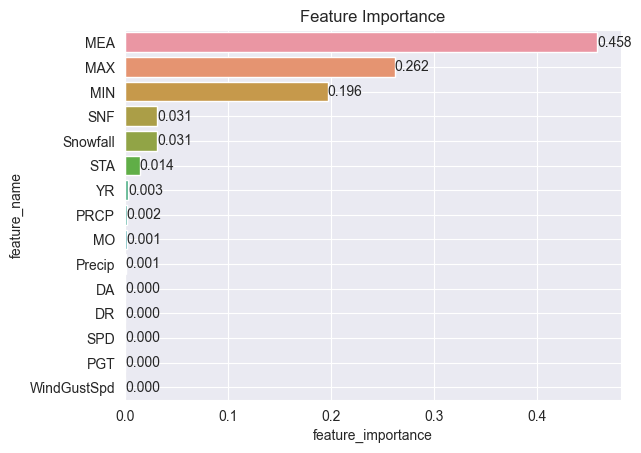

In [56]:
# feature importance
df_feature_importance = pd.DataFrame({"feature_name": model_rf_tuned.feature_names_in_, "feature_importance": model_rf_tuned.feature_importances_})
df_feature_importance = df_feature_importance.sort_values('feature_importance', ascending=False)

ax = sns.barplot(x=df_feature_importance['feature_importance'], y=df_feature_importance['feature_name'])
ax.bar_label(ax.containers[0], fmt="%.03f")
ax.grid(True)
ax.set_title('Feature Importance')

- As we can see in feature importance plot, not every features affect prediction, but it still need to be computed while fitting the model which can lead to unnecessary time consuming. 

- Imagine if we want or have to re-fit the model to predict the result with the same structure dataset but different data, like in the future, we need to compute these unnecessary features every time.

- Even you have to train the model once, it still consume so much time with big data or large dataset if we don't know how to trade-off small amount of accuracy with a big time consumption which come to **dimensionality reduction**.

*In this notebook we gonna use PCA and Kernel PCA, which can be decided by variables relationship.*

**PCA does not itself reduce features that are not important, but instead retain subset components which are low-dimension transnformed features obtained from solving equation of `C*V = λ*V` to get each principle component. So, it's not about reducing features, but discarding some of the transformed components or dimensions that are obtained through the PCA process.**

*Note:* 
- *C: Covariance Matrix - came from computing Covariance between each pair of variables (features)*
- *V: Eigenvector - obtained from solving the equation*
- *λ: Eigenvalue - obtained from solving the equation*

- `Transform data = (Feature Maxtrix(aka."scaled dataset")) * (Chosen n_components)`

*Mathematical explanation: [Analytics Vidhya](https://medium.com/analytics-vidhya/understanding-principle-component-analysis-pca-step-by-step-e7a4bb4031d9)*

In [57]:
df_input = df.drop(columns=["Date", "MaxTemp", "MinTemp", "MeanTemp"])

We can also discard some features referring to [*multicollinearity*](https://en.wikipedia.org/wiki/Multicollinearity)

<AxesSubplot:>

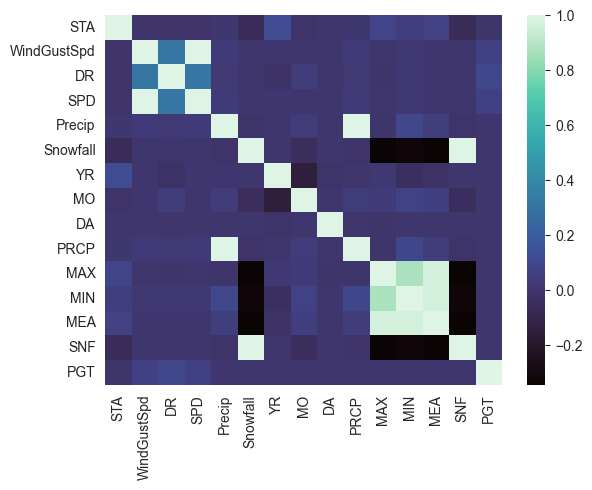

In [58]:
sns.heatmap(df_input.corr(method="pearson"), cmap='mako')

most of variables are not linearly related, so we will use KernelPCA

In [61]:
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA

In [95]:
n_features = df_input.shape[1]

# kernelpca = KernelPCA(
#     n_components=n_features,
#     kernel='rbf',
#     gamma=None
# )

pca = PCA(n_components=n_features)

scaler = RobustScaler()
scaled_df_input = scaler.fit_transform(df_input)

pca_input = pca.fit_transform(scaled_df_input)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

In [119]:
explained_variance_ratio = pca.explained_variance_ratio_
feature_names = df.columns
components = pca.components_

# Print the sorted features along with their explained variance ratio
for i, variance_ratio in enumerate(explained_variance_ratio):
    component = components[i]
    feature_importance = [(feature, abs(coeff)) for feature, coeff in zip(feature_names, component)]
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    print(f"Explained Variance Ratio: {variance_ratio}")
    for feature, importance in feature_importance:
        print(f"Feature: {feature}, Importance: {importance}")
    print()

Explained Variance Ratio: 0.5193975788417007
Feature: SPD, Importance: 0.7136951622329918
Feature: Snowfall, Importance: 0.6994697767299054
Feature: MO, Importance: 0.02584011027435377
Feature: DA, Importance: 0.01773196023425326
Feature: Precip, Importance: 0.01615206419753465
Feature: STA, Importance: 0.005976917273123411
Feature: WindGustSpd, Importance: 0.005931108454538422
Feature: MinTemp, Importance: 0.005705491106440192
Feature: Date, Importance: 0.003486260033633383
Feature: YR, Importance: 0.003346681517870237
Feature: DR, Importance: 0.0032272771453142265
Feature: MAX, Importance: 0.0006971560547819177
Feature: PRCP, Importance: 0.0006359080392731751
Feature: MaxTemp, Importance: 0.00030493910535270286
Feature: MeanTemp, Importance: 0.00012939192596364026

Explained Variance Ratio: 0.25027963197195185
Feature: Precip, Importance: 0.8992523537954228
Feature: YR, Importance: 0.29039608550681656
Feature: DA, Importance: 0.2560010196037158
Feature: MO, Importance: 0.196601217728

In [75]:
df_input.columns

Index(['STA', 'WindGustSpd', 'DR', 'SPD', 'Precip', 'Snowfall', 'YR', 'MO',
       'DA', 'PRCP', 'MAX', 'MIN', 'MEA', 'SNF', 'PGT'],
      dtype='object')

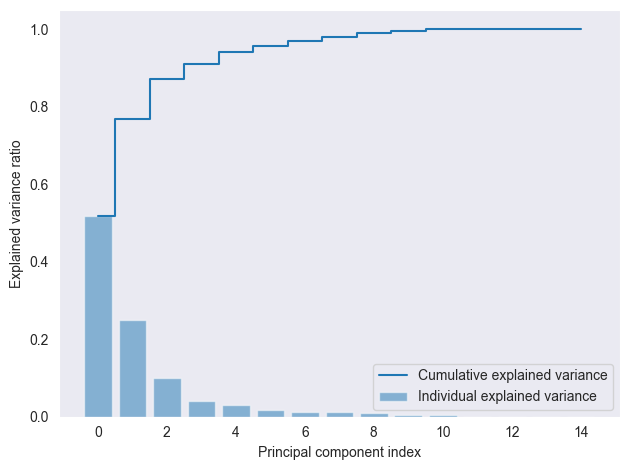

In [68]:
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()